In [1]:
import os
import torch
import config
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

### 1. Load Dataset

In [2]:
class FER2013(Dataset):
    def __init__(self, ttv, transform=None):
        '''
        Arguments:
            ttv (string): 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on image
        '''
        if ttv not in ['train', 'val', 'test']:
            raise ValueError(f"ttv={ttv} is not 'train', 'val', 'test'") 
        self.data = os.path.join(config.DATA_PATH, ttv)
        self.labels = np.load(os.path.join(config.ANNOTATIONS_PATH, ttv + '_labels.npy'))    
        self.transform = transform
        self.ttv = ttv
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_name = self.ttv + '_' + str(idx) + '.jpg'
        image = cv2.imread(os.path.join(self.data, image_name))
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.uint8)
        return image, label
    
    def get_labels(self):
        return self.labels

### 1a. Data Augmentation Strategy

Defining simple non-occlusion-aware augmentations similar to the paper *An intelligent system for monitoring students' engagement in large classroom teaching through facial expression recognition*

https://doi-org.wwwproxy1.library.unsw.edu.au/10.1111/exsy.12839

- Rotation
- Shear
- Horizontal flip
- Scale/Zoom
- Height and Width Shifting
- Resize original 200x200 resolution

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augment_tf = A.Compose([
    A.Rotate(limit=20, border_mode=cv2.BORDER_REPLICATE),
    A.Affine(shear=(-20, 20), mode=cv2.BORDER_REPLICATE),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.2),
    A.Affine(translate_percent=(-0.2, 0.2), mode=cv2.BORDER_REPLICATE),
    A.Resize(height=200, width=200, interpolation=cv2.INTER_CUBIC),
    ToTensorV2(),
])

base_tf = A.Compose([
    ToTensorV2(),
])

In [4]:
train_dataset = FER2013('train', augment_tf)
valid_dataset = FER2013('val', base_tf)
test_dataset = FER2013('test', base_tf)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### 2. Class Weights

#### 2a. Plot Dataset 

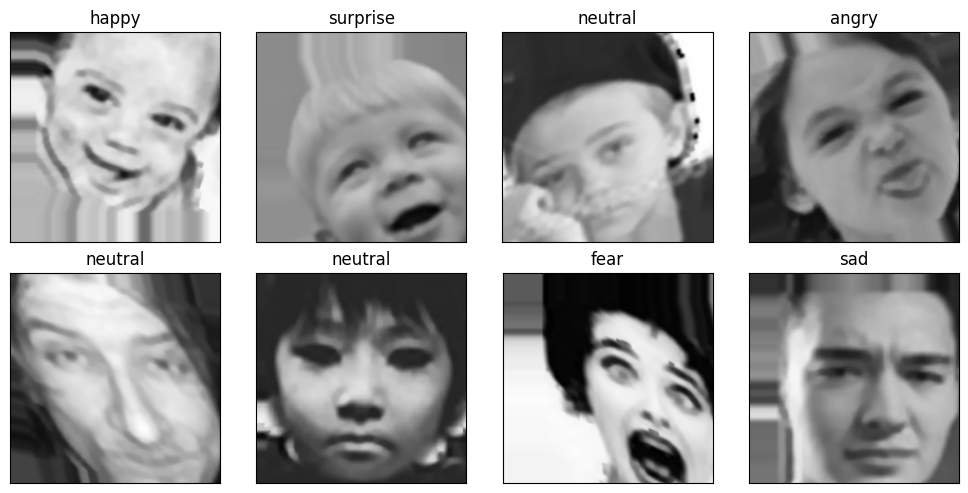

In [6]:
def plot_dataset(loader):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    class_map = {
        0: 'angry',
        1: 'disgust',
        2: 'fear', 
        3:'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'
    }
    for images, labels in loader:
        for i, ax in enumerate(axes.flat):
            image = images[i].cpu().numpy().transpose(1, 2, 0)
            label = int(labels[i].cpu())
            
            ax.imshow(image, cmap='gray')
            
            ax.set_title(f'{class_map[label]}')
        break

    plt.tight_layout()
    plt.show()

plot_dataset(train_loader)

#### 2b. Plot Class Distribution

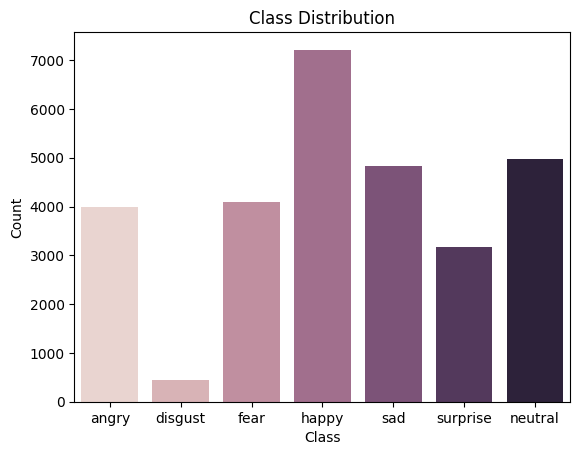

In [7]:
def plot_class_distribution(dataset):
    plot = sns.countplot(x=dataset.get_labels(), hue=dataset.get_labels(), legend=False)
    plot.set_title('Class Distribution')
    plot.set_xlabel('Class')
    plot.set_ylabel('Count')
    plot.set_xticks(range(len(CLASS_LABELS)))
    plot.set_xticklabels(CLASS_LABELS)
    
plot_class_distribution(train_dataset)

#### 2c. Create Class Weights for Imbalanced Data

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights of dataset
def get_class_weights(dataset):
    labels = dataset.get_labels()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights).float().to(DEVICE)

train_class_weights = get_class_weights(train_dataset) 
print(train_class_weights)

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')


### 3. Train and Evaluate Functions

In [9]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        accuracy = correct_predictions / total_samples    
        average_loss = running_loss / len(loader)
        
        print(f'validation_loss: {average_loss:.4f} - valid_accuracy: {accuracy:.4f}')
            
    return accuracy, average_loss, y_true, y_pred

In [10]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        '''
        Arguments:
            patience (int): number of times to allow for no improvement before stopping the execution
            min_delta (float): minimum change counted as an improvement
        '''
        self.patience = patience 
        self.min_delta = min_delta
        self.counter = 0 # internal counter
        self.min_validation_loss = np.inf

    # Return True when validation loss is not decreased by `min_delta` `patience` times 
    def early_stop(self, validation_loss):
        if ((validation_loss + self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif ((validation_loss + self.min_delta) > self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
def train_model(model, optimizer, train_loader, valid_loader, criterion, num_epochs, prefix):
    model.to(DEVICE)
    best_accuracy_train = 0
    best_accuracy_val = 0
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    best_y_true = []
    best_y_pred = []
    early_stopper = EarlyStopper(patience=10, min_delta=0)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        loop = tqdm(train_loader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
            
        train_accuracy = correct_predictions / total_samples    
        average_loss = running_loss / len(train_loader)
        
        print('.' * 64)
        print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
        print(f'train_loss: {average_loss:.4f} - train_accuracy: {train_accuracy:.4f}')
        
        if train_accuracy > best_accuracy_train:
            best_accuracy_train = train_accuracy
            torch.save(model.state_dict(), f'./models/{prefix}_best_train.pth')
            
        valid_accuracy, val_loss, y_true, y_pred = evaluate_model(model, valid_loader, criterion)
        
        if valid_accuracy > best_accuracy_val:
            best_y_true = y_true
            best_y_pred = y_pred
            best_accuracy_val = valid_accuracy
            torch.save(model.state_dict(), f'./models/{prefix}_best_valid.pth')

        train_acc.append(train_accuracy)
        train_loss.append(average_loss)
        valid_acc.append(valid_accuracy)
        valid_loss.append(val_loss)
        
        if early_stopper.early_stop(val_loss):
            print(f'Stopping early at Epoch {epoch + 1}, validation loss failed to decrease')
            break

    return {
        'train_accuracy': train_acc,
        'train_loss': train_loss,
        'valid_accuracy': valid_acc,
        'valid_loss': valid_loss,
        'y_true': best_y_true,
        'y_pred': best_y_pred
    }

### 4. Train Model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [12]:
# ResNet50
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
# Edit final model classifier layer  
model.fc = nn.Linear(in_features=2048, out_features=len(np.unique(train_dataset.get_labels())), bias=True)

In [13]:
results = train_model(model, optimizer, train_loader, valid_loader, criterion, 30, 'ResNet50')

  0%|          | 0/898 [00:00<?, ?it/s]/home/vincent/anaconda3/envs/projects/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


................................................................
--- Epoch 1/30 ---
train_loss: 1.6469 - train_accuracy: 0.3821
validation_loss: 1.5358 - valid_accuracy: 0.4411


................................................................
--- Epoch 2/30 ---
train_loss: 1.4636 - train_accuracy: 0.4551
validation_loss: 1.4595 - valid_accuracy: 0.4781


................................................................
--- Epoch 3/30 ---
train_loss: 1.3863 - train_accuracy: 0.4888
validation_loss: 1.3301 - valid_accuracy: 0.4946


................................................................
--- Epoch 4/30 ---
train_loss: 1.3590 - train_accuracy: 0.4997
validation_loss: 1.3527 - valid_accuracy: 0.5116


................................................................
--- Epoch 5/30 ---
train_loss: 1.3076 - train_accuracy: 0.5183
validation_loss: 1.2714 - valid_accuracy: 0.5561


................................................................
--- Epoch 6/30 ---
train_loss: 1.2911 - train_accuracy: 0.5220
validation_loss: 1.4266 - valid_accuracy: 0.4862


................................................................
--- Epoch 7/30 ---
train_loss: 1.2648 - train_accuracy: 0.5324
validation_loss: 1.2608 - valid_accuracy: 0.5548


................................................................
--- Epoch 8/30 ---
train_loss: 1.2346 - train_accuracy: 0.5391
validation_loss: 1.2362 - valid_accuracy: 0.5428


................................................................
--- Epoch 9/30 ---
train_loss: 1.2260 - train_accuracy: 0.5433
validation_loss: 1.2682 - valid_accuracy: 0.5297


................................................................
--- Epoch 10/30 ---
train_loss: 1.2059 - train_accuracy: 0.5474
validation_loss: 1.1470 - valid_accuracy: 0.5628


................................................................
--- Epoch 11/30 ---
train_loss: 1.1824 - train_accuracy: 0.5538
validation_loss: 1.1797 - valid_accuracy: 0.5882


................................................................
--- Epoch 12/30 ---
train_loss: 1.1661 - train_accuracy: 0.5629
validation_loss: 1.2029 - valid_accuracy: 0.5667


................................................................
--- Epoch 13/30 ---
train_loss: 1.1574 - train_accuracy: 0.5644
validation_loss: 1.1959 - valid_accuracy: 0.5809


................................................................
--- Epoch 14/30 ---
train_loss: 1.1418 - train_accuracy: 0.5691
validation_loss: 1.2245 - valid_accuracy: 0.5486


................................................................
--- Epoch 15/30 ---
train_loss: 1.1392 - train_accuracy: 0.5721
validation_loss: 1.1968 - valid_accuracy: 0.5389


................................................................
--- Epoch 16/30 ---
train_loss: 1.1262 - train_accuracy: 0.5780
validation_loss: 1.1475 - valid_accuracy: 0.5762


................................................................
--- Epoch 17/30 ---
train_loss: 1.1033 - train_accuracy: 0.5855
validation_loss: 1.1619 - valid_accuracy: 0.5854


................................................................
--- Epoch 18/30 ---
train_loss: 1.0975 - train_accuracy: 0.5852
validation_loss: 1.1346 - valid_accuracy: 0.5790


................................................................
--- Epoch 19/30 ---
train_loss: 1.0835 - train_accuracy: 0.5923
validation_loss: 1.1611 - valid_accuracy: 0.5812


................................................................
--- Epoch 20/30 ---
train_loss: 1.0809 - train_accuracy: 0.5912
validation_loss: 1.1425 - valid_accuracy: 0.5617


................................................................
--- Epoch 21/30 ---
train_loss: 1.0806 - train_accuracy: 0.5918
validation_loss: 1.1195 - valid_accuracy: 0.5751


................................................................
--- Epoch 22/30 ---
train_loss: 1.0660 - train_accuracy: 0.5978
validation_loss: 1.1270 - valid_accuracy: 0.5670


................................................................
--- Epoch 23/30 ---
train_loss: 1.0558 - train_accuracy: 0.5988
validation_loss: 1.0623 - valid_accuracy: 0.6130


................................................................
--- Epoch 24/30 ---
train_loss: 1.0397 - train_accuracy: 0.6036
validation_loss: 1.1413 - valid_accuracy: 0.5857


................................................................
--- Epoch 25/30 ---
train_loss: 1.0447 - train_accuracy: 0.6034
validation_loss: 1.1178 - valid_accuracy: 0.6018


................................................................
--- Epoch 26/30 ---
train_loss: 1.0281 - train_accuracy: 0.6069
validation_loss: 1.1571 - valid_accuracy: 0.5921


................................................................
--- Epoch 27/30 ---
train_loss: 1.0426 - train_accuracy: 0.6070
validation_loss: 1.0559 - valid_accuracy: 0.6032


................................................................
--- Epoch 28/30 ---
train_loss: 1.0159 - train_accuracy: 0.6111
validation_loss: 1.1033 - valid_accuracy: 0.6049


................................................................
--- Epoch 29/30 ---
train_loss: 1.0204 - train_accuracy: 0.6122
validation_loss: 1.1294 - valid_accuracy: 0.5910


................................................................
--- Epoch 30/30 ---
train_loss: 1.0211 - train_accuracy: 0.6086
validation_loss: 1.2627 - valid_accuracy: 0.5419


### 5. Model Evaluation

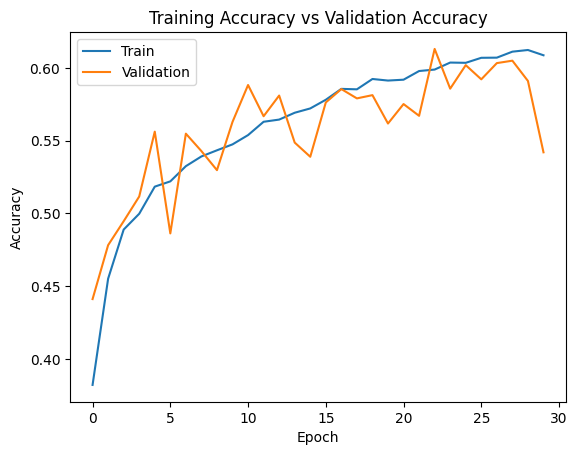

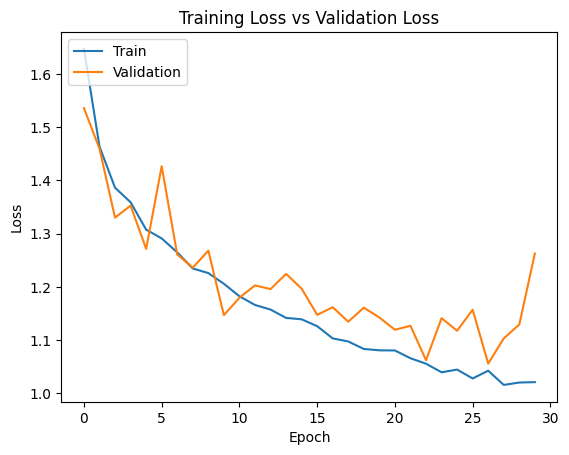

In [14]:
def plot_training_history(results):
    plt.figure()
    plt.plot(results['train_accuracy'])
    plt.plot(results['valid_accuracy'])
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.figure()
    plt.plot(results['train_loss'])
    plt.plot(results['valid_loss'])
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
plot_training_history(results)

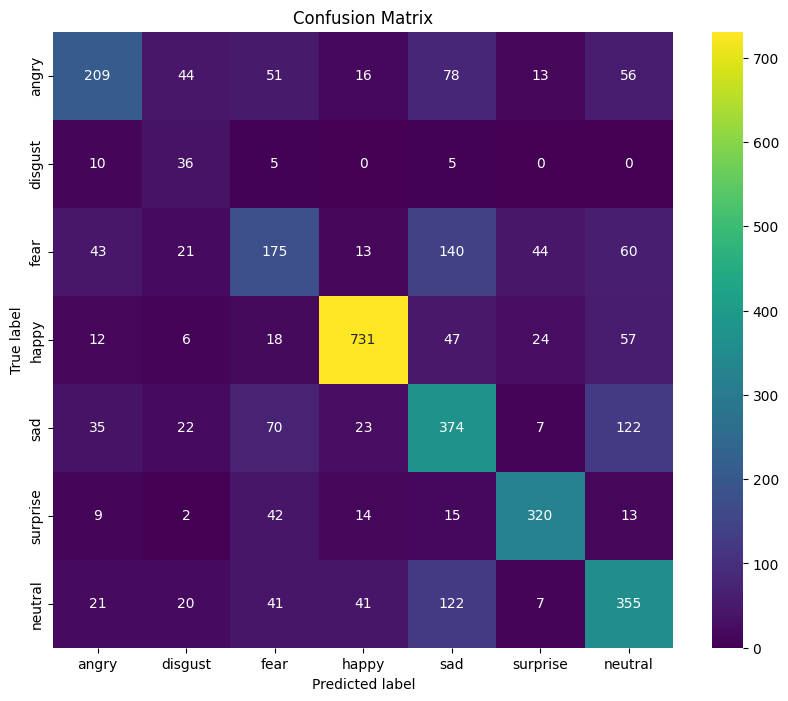

In [15]:
def plot_confusion_matrix(results):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(results)

In [16]:
def display_classification_report(results):
    print('=== Classification Report ===')
    print(classification_report(results['y_true'], results['y_pred'], target_names=CLASS_LABELS, digits=4))

display_classification_report(results)

=== Classification Report ===
              precision    recall  f1-score   support

       angry     0.6165    0.4475    0.5186       467
     disgust     0.2384    0.6429    0.3478        56
        fear     0.4353    0.3528    0.3898       496
       happy     0.8723    0.8168    0.8436       895
         sad     0.4789    0.5727    0.5216       653
    surprise     0.7711    0.7711    0.7711       415
     neutral     0.5354    0.5848    0.5591       607

    accuracy                         0.6130      3589
   macro avg     0.5640    0.5984    0.5645      3589
weighted avg     0.6285    0.6130    0.6158      3589



### 6. Model Predictions

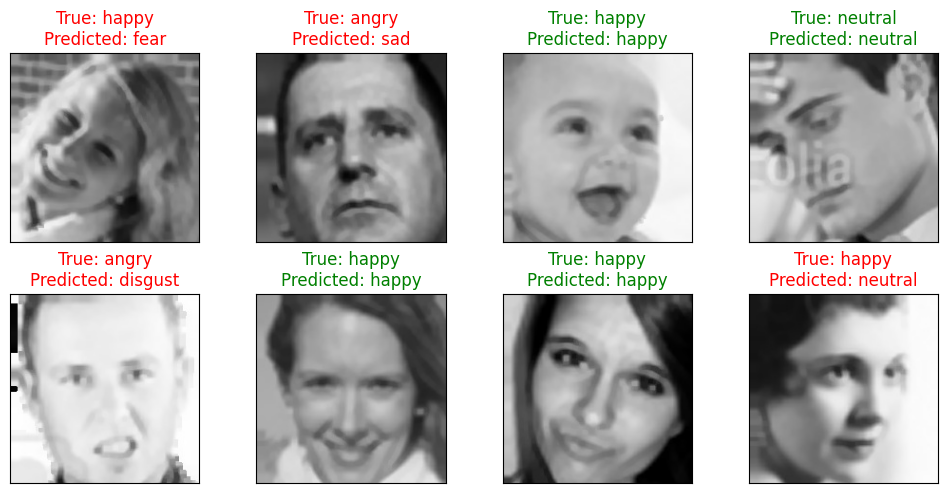

In [19]:
# Load model
MODEL_PATH = './models/ResNet50_best_valid.pth'
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.fc = nn.Linear(in_features=2048, out_features=len(np.unique(train_dataset.get_labels())), bias=True)
model.load_state_dict(torch.load(MODEL_PATH))

def plot_predictions(model, loader):
    model.to(DEVICE)
    model.eval()
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    class_map = {
        0: 'angry',
        1: 'disgust',
        2: 'fear', 
        3:'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'
    }
    # Make prediction on test set
    with torch.no_grad():
        for inputs, true_labels in loader:
            inputs, true_labels = inputs.to(DEVICE), true_labels.to(DEVICE)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)

            for i, ax in enumerate(axes.flat):
                image = inputs[i].cpu().numpy().transpose(1, 2, 0)
                true_label = int(true_labels[i].cpu())
                pred_label = int(predicted[i].cpu())
                
                ax.imshow(image, cmap='gray')
                
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f'True: {class_map[true_label]}\nPredicted: {class_map[pred_label]}', color=color)
            break # break early to test only 1 batch

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader)

### Areas for Improvements
TODO: 
- ~~Implement early stopping (5-10 epochs)~~
- ~~Computing class weights to scale imbalanced data~~
- ~~Baseline non-occlusion-aware-like data augmentation and pre-processing~~
- ~~Transfer learning e.g. using ImageNet as base model~~
- Trying different models, optimizers and criterion
- ~~Train for 30 epochs~~
- Look at CompreFace for face detection
- NCI access
- Create benchmark with other papers using FER-2013
